# Funções auxiliares

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime, date
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from collections import Counter

class AtributosNumericos(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.colunasNumericas = X.select_dtypes(include='number').columns
        return self
    def transform(self, X, y=None):
        return X[self.colunasNumericas].to_numpy() 

class AtributosCategoricos(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.colunasCategoricas = X.select_dtypes(exclude='number').columns
        return self
    def transform(self, X, y=None):
        return X[self.colunasCategoricas].to_numpy()

def calcularTempoAlunoCurso(entrada):
    formatoData = "%d/%m/%Y"
    dataEntrada = datetime.strptime(entrada, formatoData).date()
    today = date.today()
    return today.year - dataEntrada.year

def extrairRenda(entrada):
    if ((entrada == 'Não declarada') or (entrada == 'NÃO DECLARADA')):
        renda = 0
    else:
        if (entrada.find('>') >=0):
            
            renda = float(entrada[entrada.find('>')+1:].replace(',','.'))
        elif (entrada.find('<') >=0): 
            renda = float(entrada[entrada.find('<=')+2:].replace(',','.'))
        else:
            renda = entrada
    return renda    


class AtributosDesejados(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.colunasIndesejadas = ['Aluno','InstituicaoEducacional','TipoLocalizacao']
        #self.colunasIndesejadas = ['Aluno','InstituicaoEducacional']
        return self
    def transform(self, X, y=None):
        Xdrop = X.drop(self.colunasIndesejadas,axis=1)
        #Xdrop['Matricula'] = Xdrop['Matricula'].apply(calcularTempoAlunoCurso)
        #Xdrop['Idade'] = Xdrop['Idade']/10
        if 'Renda' in X:
            X['Renda'] = X['Renda'].apply(extrairRenda)
        return Xdrop      

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ZeroR():
    def fit(self, X, y):
        self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        y[:] = self.resposta
        return y

In [6]:
import pandas as pd
import math


def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

# Carregando dados atuais

In [7]:
import numpy as np
import pandas as pd

#Parametros
arquivoBaseDadosAtuais = './dados/pnp2021/RepositorioPnp2021-ifes.csv'
separadorCsvBaseDadosAtuais=';'
arquivoSituacoesEvasaoBase='./dados/pnp2021/situacoes.csv'
separadorCsvSituacaoesEvasao=';'
arquivoResultado = './dados/dadosEvasao'
separadorCsvArquivoResultado=';'

#Ler situações que são consideradas evasão
situacoes_evasao = pd.read_csv(arquivoSituacoesEvasaoBase,separadorCsvSituacaoesEvasao)
situacoes_evasao=situacoes_evasao['SituacaoEvasao'].to_numpy()

#Ler Base de dados
dfAtual=pd.read_csv(arquivoBaseDadosAtuais,separadorCsvBaseDadosAtuais)

#dfAtual = dfAtual.apply(lambda x: x.astype(str).str.upper())

dfAtualCopia = dfAtual

y_atual = dfAtual['SituacaoMatricula']

y_atual_binary = np.where(np.isin(y_atual,situacoes_evasao),1,0 )



print(np.count_nonzero(y_atual_binary==1))


2411


c:\Users\eduardomoura\.venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tabela comparando as métricas de avaliação


,Accuracy,Precision,Recall,F1-Score
Extra Trees,0.613344,0.089523,0.528411,0.153107
Ada Boost,0.820526,0.104235,0.225633,0.142595
Decision Trees,0.480782,0.070838,0.565326,0.125901
ZeroR,0.933856,0.000000,0.000000,0.000000
Random Forest,0.645305,0.080220,0.416839,0.134547
KNN,0.585334,0.083803,0.530485,0.144741
Bagging,0.830073,0.105362,0.209457,0.140200
Gradient Boosting,0.603440,0.098105,0.609706,0.169014


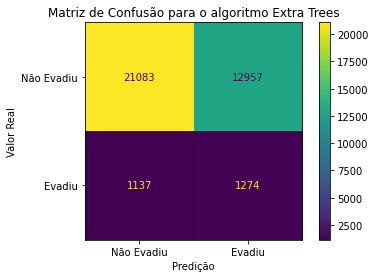

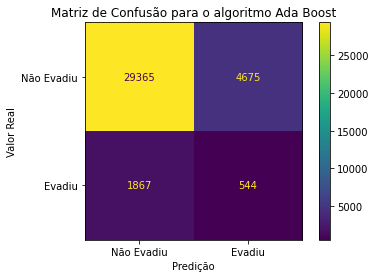

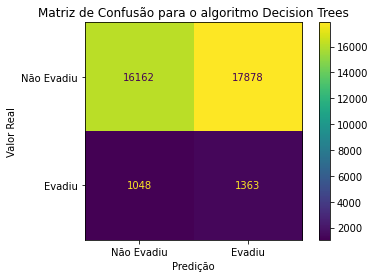

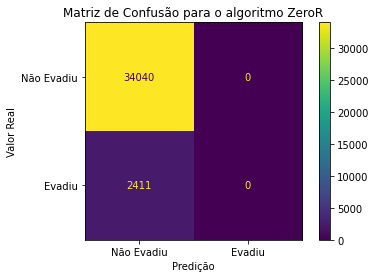

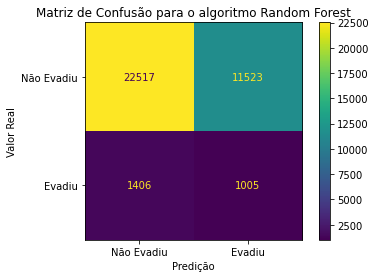

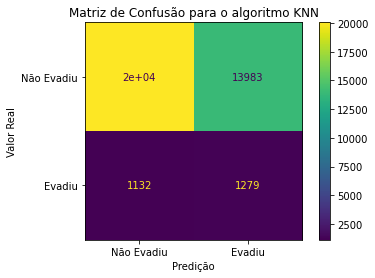

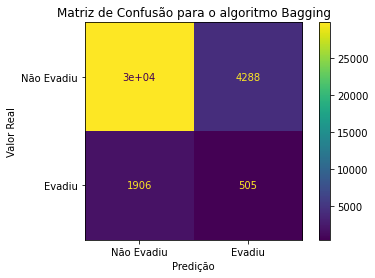

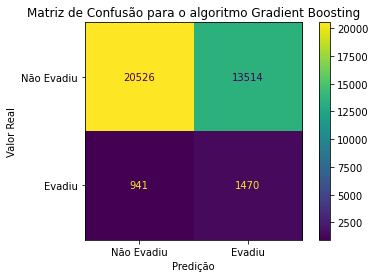

In [8]:
import pickle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  
models = {'ZeroR','Decision Trees','KNN','Random Forest','Extra Trees','Ada Boost','Bagging','Gradient Boosting'}
accuracy, precision, recall, f1 = {}, {}, {},{}

for model in models:
    X_atual = dfAtual.drop(['SituacaoMatricula'],axis=1)
    X_atual2 = dfAtual.drop(['SituacaoMatricula'],axis=1)
    nomeModelo=model+'.pkl'
    pickled_model = pickle.load(open(nomeModelo, 'rb'))
    y_predict = pickled_model.predict(X_atual)

    cm = confusion_matrix(y_atual_binary, y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Não Evadiu','Evadiu'])
                            
    disp.plot()
    disp.ax_.set(xlabel='Predição', ylabel='Valor Real',title="Matriz de Confusão para o algoritmo "+ model) 

    if(model !='ZeroR'):
        proba = pickled_model.predict_proba(X_atual2)
        dfAtualCopia['Predicao'] = y_predict
        dfAtualCopia['ProbabilidadeEvasao'] = proba[0:,1:].round(decimals=2)

        dfAtualCopia.to_csv(arquivoResultado+model+'.csv',sep = separadorCsvBaseDadosAtuais, index = False)

    accuracy[model] = accuracy_score(y_atual_binary,y_predict)
    precision[model] = precision_score(y_atual_binary,y_predict)
    f1[model] = f1_score(y_atual_binary,y_predict)
    recall[model] = recall_score(y_atual_binary,y_predict)

df_model = pd.DataFrame(index=models, columns=['Accuracy', 'Precision','Recall','F1-Score'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['F1-Score'] = f1.values()
df_model['Recall'] = recall.values()

print('Tabela comparando as métricas de avaliação')
df_model.style.highlight_max(color = 'lightgreen', axis = 0)




